In [1]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/

In [2]:
!kaggle datasets download -d paultimothymooney/chest-xray-pneumonia

100% 2.29G/2.29G [00:59<00:00, 43.1MB/s]
100% 2.29G/2.29G [00:59<00:00, 41.2MB/s]


In [3]:
import zipfile
zip_ref = zipfile.ZipFile('/content/chest-xray-pneumonia.zip', 'r')
zip_ref.extractall('/content')
zip_ref.close()

In [4]:
import cv2
import os
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import tensorflow as tf
from tensorflow import keras
from keras import Sequential
from keras.layers import *
from keras.losses import BinaryCrossentropy
from sklearn.preprocessing import LabelEncoder
from keras.optimizers import Adam , Adamax
from keras.applications import *
from keras.callbacks import EarlyStopping
import warnings
warnings.filterwarnings("ignore")



In [5]:
directory = "/content/chest_xray/train"

filepath =[]
label = []

folds = os.listdir(directory)

for fold in folds:
    f_path = os.path.join(directory , fold)

    imgs = os.listdir(f_path)

    for img in imgs:
        img_path = os.path.join(f_path , img)
        filepath.append(img_path)
        label.append(fold)

file_path_series = pd.Series(filepath , name= 'filepath')
Label_path_series = pd.Series(label , name = 'label')
df_train = pd.concat([file_path_series ,Label_path_series ] , axis = 1)

In [6]:
df_train

filepath      label
0     /content/chest_xray/train/PNEUMONIA/person568_...  PNEUMONIA
1     /content/chest_xray/train/PNEUMONIA/person315_...  PNEUMONIA
2     /content/chest_xray/train/PNEUMONIA/person318_...  PNEUMONIA
3     /content/chest_xray/train/PNEUMONIA/person265_...  PNEUMONIA
4     /content/chest_xray/train/PNEUMONIA/person5_ba...  PNEUMONIA
...                                                 ...        ...
5211  /content/chest_xray/train/NORMAL/IM-0467-0001-...     NORMAL
5212  /content/chest_xray/train/NORMAL/NORMAL2-IM-13...     NORMAL
5213  /content/chest_xray/train/NORMAL/IM-0324-0001....     NORMAL
5214  /content/chest_xray/train/NORMAL/NORMAL2-IM-10...     NORMAL
5215  /content/chest_xray/train/NORMAL/IM-0241-0001....     NORMAL

[5216 rows x 2 columns]

In [7]:
directory = "/content/chest_xray/test"

filepath =[]
label = []

folds = os.listdir(directory)

for fold in folds:
    f_path = os.path.join(directory , fold)

    imgs = os.listdir(f_path)

    for img in imgs:

        img_path = os.path.join(f_path , img)
        filepath.append(img_path)
        label.append(fold)
#Concat data paths with labels
file_path_series = pd.Series(filepath , name= 'filepath')
Label_path_series = pd.Series(label , name = 'label')
df_test = pd.concat([file_path_series ,Label_path_series ] , axis = 1)

In [8]:
df_test.sample(5)

filepath      label
119  /content/chest_xray/test/PNEUMONIA/person95_ba...  PNEUMONIA
233  /content/chest_xray/test/PNEUMONIA/person56_vi...  PNEUMONIA
108  /content/chest_xray/test/PNEUMONIA/person137_b...  PNEUMONIA
163  /content/chest_xray/test/PNEUMONIA/person69_vi...  PNEUMONIA
546  /content/chest_xray/test/NORMAL/NORMAL2-IM-002...     NORMAL

In [9]:
print(f"The shape of The Train data is: {df_train.shape}")
print(f"The shape of The Test data is: {df_test.shape}")

The shape of The Train data is: (5216, 2)
The shape of The Test data is: (624, 2)


In [10]:
#Data_Dir
data_dir = '/content/chest_xray/train'
test_dir = '/content/chest_xray/test'

IMAGE_SIZE = (256,256)

print('Training Images:')
# Creating the training dataset
train_ds = tf.keras.utils.image_dataset_from_directory(
    data_dir,
    validation_split=0.1,
    subset='training',
    seed=123,
    image_size=IMAGE_SIZE,
    batch_size=32)
#Testing  Data
print('Validation Images:')
validation_ds = tf.keras.utils.image_dataset_from_directory(
    data_dir,
    validation_split=0.1,
    subset='validation',
    seed=123,
    image_size=IMAGE_SIZE,
    batch_size=32)

print('Testing Images:')
test_ds = tf.keras.utils.image_dataset_from_directory(
    test_dir,
    seed=123,
    image_size=IMAGE_SIZE,
    batch_size=32)

Training Images:
Found 5216 files belonging to 2 classes.
Using 4695 files for training.
Validation Images:
Found 5216 files belonging to 2 classes.
Using 521 files for validation.
Testing Images:
Found 624 files belonging to 2 classes.


In [11]:
# Extract labels
train_labels = train_ds.class_names
test_labels = test_ds.class_names
validation_labels = validation_ds.class_names

# Encode Labels

# Define your class labels
class_labels = ['NORMAL', 'PNEUMONIA']

# Instantiate LabelEncoder
label_encoder = LabelEncoder()

# Fit label encoder on the class labels
label_encoder.fit(class_labels)

# Transform the labels for training dataset
train_labels_encoded = label_encoder.transform(train_labels)

# Transform the labels for validation dataset
validation_labels_encoded = label_encoder.transform(validation_labels)

# Transform the labels for test dataset
test_labels_encoded = label_encoder.transform(test_labels)

In [12]:
# Shape of the dataset
for image_batch, labels_batch in train_ds:
    print("Shape of X_train: ", image_batch.shape)
    print("Shape of y_train: ", labels_batch.shape)
    break

Shape of X_train:  (32, 256, 256, 3)
Shape of y_train:  (32,)


In [13]:
# Normalizing Pixel Values

# Train Data
train_ds = train_ds.map(lambda x, y: (x / 255.0, y))
# Val Data
validation_ds = validation_ds.map(lambda x, y: (x / 255.0, y))
# Test Data
test_ds = test_ds.map(lambda x, y: (x / 255.0, y))

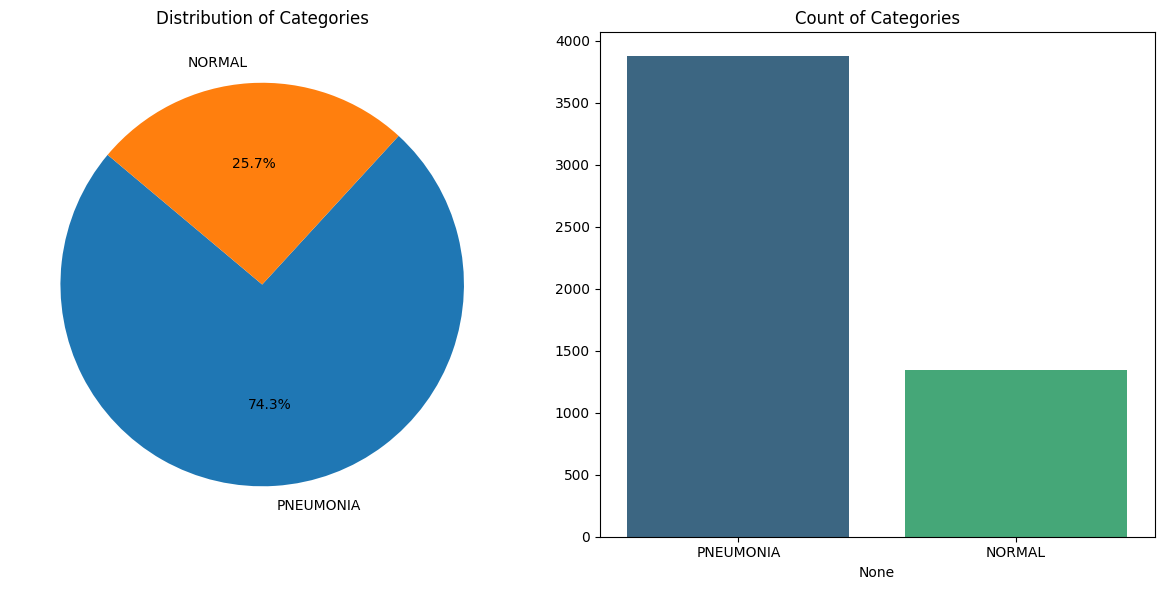

In [14]:
# Count the occurrences of each category in the 'category' column
count = df_train['label'].value_counts()

# Create a figure with two subplots
fig, axs = plt.subplots(1, 2, figsize=(12, 6), facecolor='white')

# Plot pie chart on the first subplot
palette = sns.color_palette("viridis")
sns.set_palette(palette)
axs[0].pie(count, labels=count.index, autopct='%1.1f%%', startangle=140)
axs[0].set_title('Distribution of Categories')

# Plot bar chart on the second subplot
sns.barplot(x=count.index, y=count.values, ax=axs[1], palette="viridis")
axs[1].set_title('Count of Categories')

# Adjust layout
plt.tight_layout()

# Show the plot
plt.show()

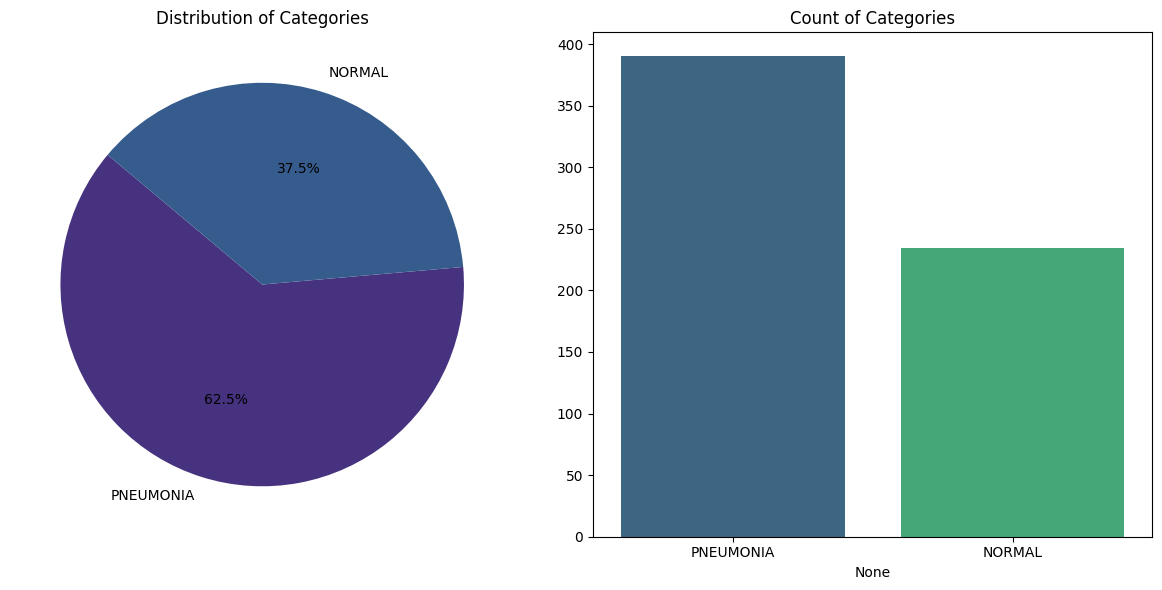

In [15]:
# Count the occurrences of each category in the 'category' column
count = df_test['label'].value_counts()

# Create a figure with two subplots
fig, axs = plt.subplots(1, 2, figsize=(12, 6), facecolor='white')

# Plot pie chart on the first subplot
palette = sns.color_palette("viridis")
sns.set_palette(palette)
axs[0].pie(count, labels=count.index, autopct='%1.1f%%', startangle=140)
axs[0].set_title('Distribution of Categories')

# Plot bar chart on the second subplot
sns.barplot(x=count.index, y=count.values, ax=axs[1], palette="viridis")
axs[1].set_title('Count of Categories')

# Adjust layout
plt.tight_layout()

# Show the plot
plt.show()

In [16]:
def visualize_images(path, num_images=5):
    # Get a list of image filenames in the specified path
    image_filenames = os.listdir(path)

    # Limit the number of images to visualize if there are more than num_images
    num_images = min(num_images, len(image_filenames))

    # Create a figure and axis object to display images
    fig, axes = plt.subplots(1, num_images, figsize=(15, 3),facecolor='white')


    # Iterate over the selected images and display them
    for i, image_filename in enumerate(image_filenames[:num_images]):
        # Load the image using Matplotlib
        image_path = os.path.join(path, image_filename)
        image = mpimg.imread(image_path)

        # Display the image
        axes[i].imshow(image)
        axes[i].axis('off')  # Turn off axis
        axes[i].set_title(image_filename)  # Set image filename as title

    # Adjust layout and display the figure
    plt.tight_layout()
    plt.show()

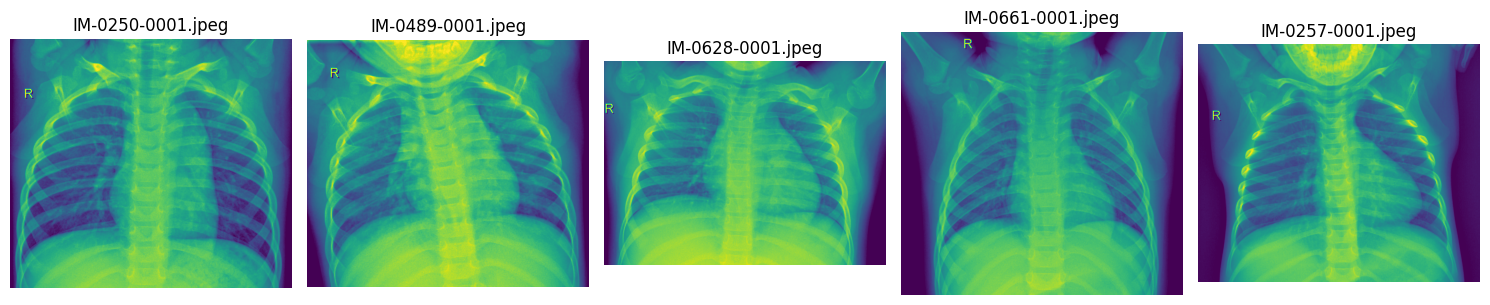

In [17]:
# Specify the path containing the images to visualize
path_to_visualize = "/content/chest_xray/train/NORMAL"

# Visualize some images from the specified path
visualize_images(path_to_visualize, num_images=5)

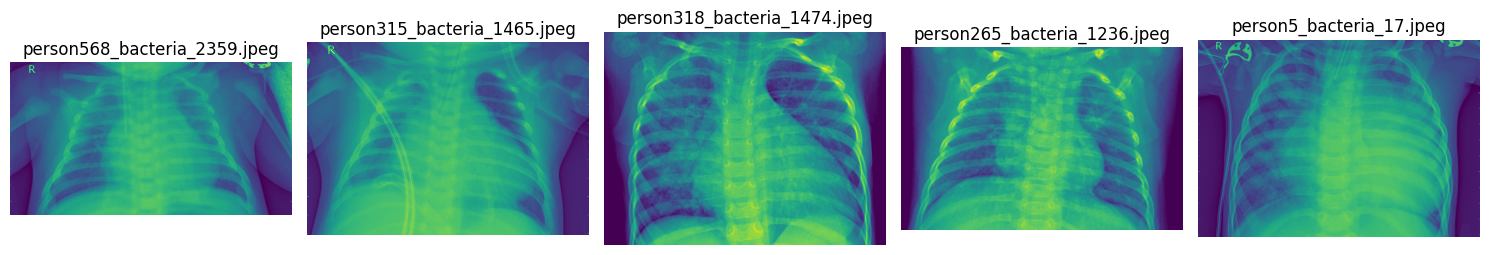

In [18]:
# Specify the path containing the images to visualize
path_to_visualize = "/content/chest_xray/train/PNEUMONIA"

# Visualize some images from the specified path
visualize_images(path_to_visualize, num_images=5)

In [19]:
model=Sequential()

model.add(Conv2D(32,(3,3),padding='same',activation='relu',input_shape=(256,256,3)))
model.add(MaxPooling2D(2,2))
model.add(SpatialDropout2D(0.1))

model.add(Conv2D(32,(3,3),padding='same',activation='relu'))
model.add(MaxPooling2D(2,2))
model.add(BatchNormalization())
model.add(SpatialDropout2D(0.2))

model.add(Conv2D(32,(3,3),padding='same',activation='relu'))
model.add(MaxPooling2D(2,2))
model.add(BatchNormalization())
model.add(SpatialDropout2D(0.2))

model.add(Conv2D(32,(3,3),padding='same',activation='relu'))
model.add(MaxPooling2D(2,2))
model.add(BatchNormalization())
model.add(SpatialDropout2D(0.3))

model.add(Conv2D(32,(3,3),padding='same',activation='relu'))
model.add(MaxPooling2D(2,2))
model.add(BatchNormalization())
model.add(SpatialDropout2D(0.3))

model.add(Conv2D(32,(3,3),padding='same',activation='relu'))
model.add(MaxPooling2D(2,2))
model.add(BatchNormalization())
model.add(SpatialDropout2D(0.3))

model.add(Conv2D(32,(3,3),padding='same',activation='relu'))
model.add(MaxPooling2D(2,2))
model.add(BatchNormalization())
model.add(SpatialDropout2D(0.5))

model.add(Flatten())
model.add(Dropout(0.5))
model.add(Dense(128,activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(128,activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(1,activation='sigmoid'))

model.compile(optimizer = "rmsprop" , loss = 'binary_crossentropy' , metrics = ['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 256, 256, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2  (None, 128, 128, 32)      0         
 D)                                                              
                                                                 
 spatial_dropout2d (Spatial  (None, 128, 128, 32)      0         
 Dropout2D)                                                      
                                                                 
 conv2d_1 (Conv2D)           (None, 128, 128, 32)      9248      
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 64, 64, 32)        0         
 g2D)                                                            
                                                        

In [20]:
model.compile(optimizer = "rmsprop" ,
            loss = 'binary_crossentropy' ,
            metrics = ['accuracy'])

In [21]:
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

#Fitting Model
history = model.fit_generator(train_ds,
                        epochs= 20,
                        validation_data = validation_ds,
                        callbacks = early_stopping)

Epoch 1/20
147/147 [==============================] - 50s 266ms/step - loss: 0.7283 - accuracy: 0.6978 - val_loss: 0.9952 - val_accuracy: 0.7639
Epoch 2/20
147/147 [==============================] - 41s 266ms/step - loss: 0.4983 - accuracy: 0.7683 - val_loss: 1.3927 - val_accuracy: 0.7639
Epoch 3/20
147/147 [==============================] - 37s 245ms/step - loss: 0.3669 - accuracy: 0.8313 - val_loss: 1.2824 - val_accuracy: 0.7658
Epoch 4/20
147/147 [==============================] - 37s 243ms/step - loss: 0.3091 - accuracy: 0.8643 - val_loss: 0.6989 - val_accuracy: 0.8100
Epoch 5/20
147/147 [==============================] - 39s 258ms/step - loss: 0.3070 - accuracy: 0.8728 - val_loss: 0.3293 - val_accuracy: 0.8964
Epoch 6/20
147/147 [==============================] - 39s 257ms/step - loss: 0.2611 - accuracy: 0.8990 - val_loss: 0.2980 - val_accuracy: 0.9290
Epoch 7/20
147/147 [==============================] - 39s 257ms/step - loss: 0.2486 - accuracy: 0.9050 - val_loss: 0.3017 - val_ac

In [22]:
# Evaluate the model on the validation dataset
validation_loss, validation_accuracy = model.evaluate(validation_ds)

# Print the validation loss and accuracy
print("Validation Loss:", validation_loss)
print("Validation Accuracy:", validation_accuracy)

17/17 [==============================] - 3s 99ms/step - loss: 0.2892 - accuracy: 0.9616
Validation Loss: 0.289174884557724
Validation Accuracy: 0.9616122841835022


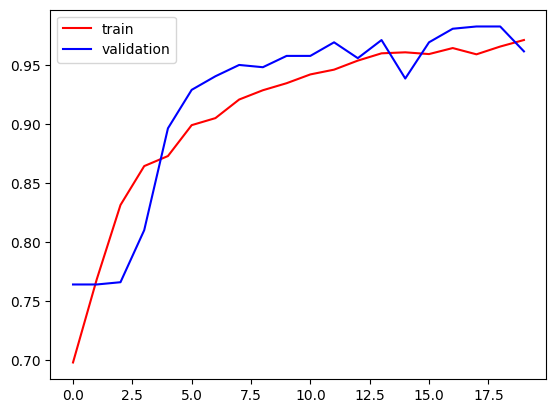

In [23]:
import matplotlib.pyplot as plt

plt.plot(history.history['accuracy'],color='red',label='train')
plt.plot(history.history['val_accuracy'],color='blue',label='validation')
plt.legend()
plt.show()

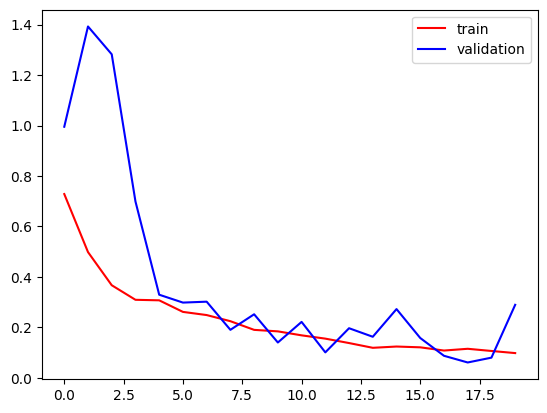

In [24]:
plt.plot(history.history['loss'],color='red',label='train')
plt.plot(history.history['val_loss'],color='blue',label='validation')
plt.legend()
plt.show()

Testing Images:
Found 624 files belonging to 2 classes.
Testing Images:
20/20 [==============================] - 4s 123ms/step


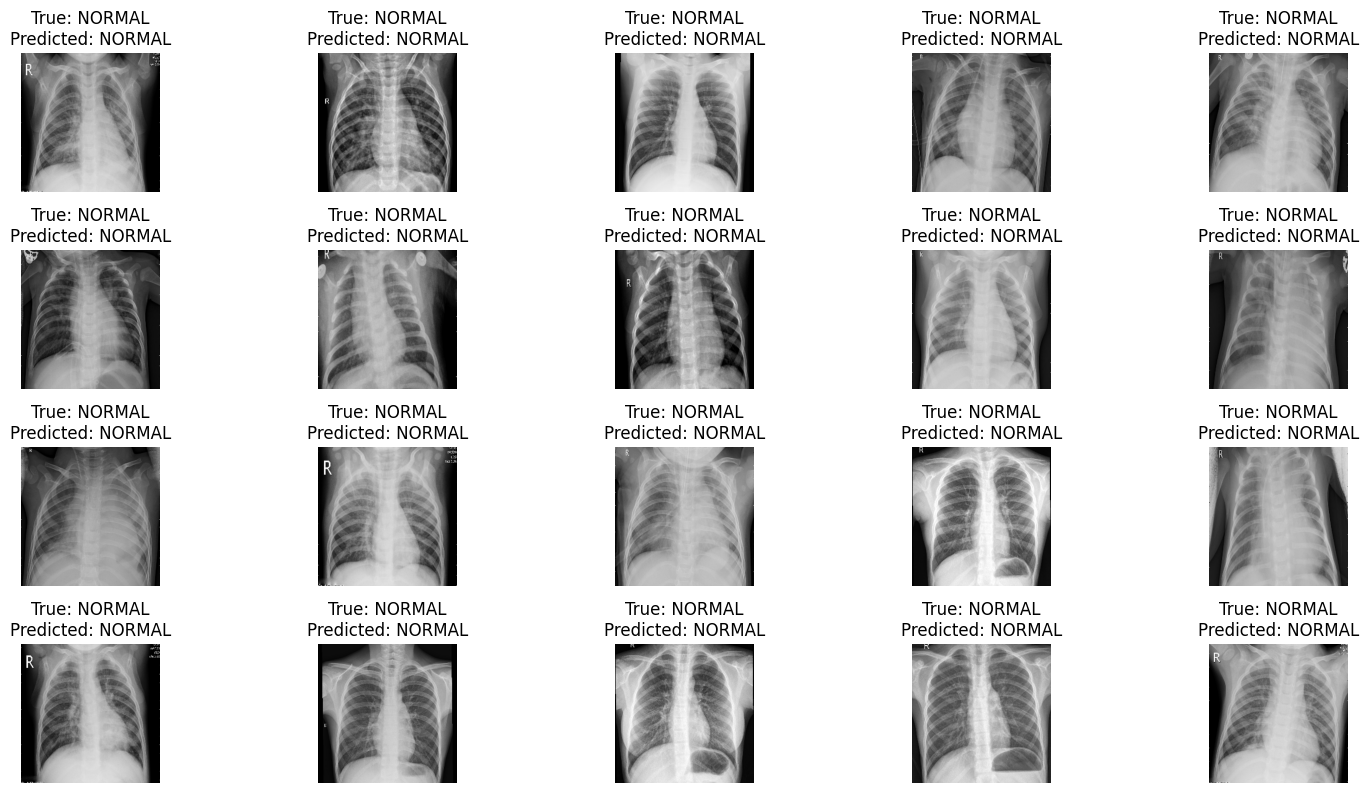

In [25]:
test_dir = '/content/chest_xray/test'
print('Testing Images:')
test_ds = tf.keras.utils.image_dataset_from_directory(
    test_dir,
    seed=123,
    image_size=IMAGE_SIZE,
    batch_size=32)

# Define a function to plot images with their true and predicted labels
def plot_images_with_predictions(model, dataset, class_labels, num_images=40, num_images_per_row=5):
    # Generate predictions for a set number of images
    predictions = model.predict(dataset)
    # Shuffle the dataset
    dataset_shuffled = dataset.shuffle(buffer_size=len(dataset))

    plt.figure(figsize=(15, 10))
    for i, (images, labels) in enumerate(dataset_shuffled.take(num_images)):
        # Convert tensor to NumPy array
        images = images.numpy()

        # Iterate over each image in the batch
        for j in range(len(images)):
            if i * num_images_per_row + j < num_images:  # Check if the total number of images exceeds the desired count
                predicted_class = class_labels[np.argmax(predictions[i * num_images_per_row + j])]
                true_class = class_labels[np.argmax(labels[j])]
                plt.subplot(num_images // num_images_per_row + 1, num_images_per_row, i * num_images_per_row + j + 1)
                plt.imshow(images[j].astype("uint8"))
                plt.title(f'True: {true_class}\nPredicted: {predicted_class}')
                plt.axis('off')

    plt.tight_layout()
    plt.show()

# Visualize predictions on random 20 images from the testing dataset
print('Testing Images:')
plot_images_with_predictions(model, test_ds, class_labels, num_images=20)

1/1 [==============================] - 0s 18ms/step


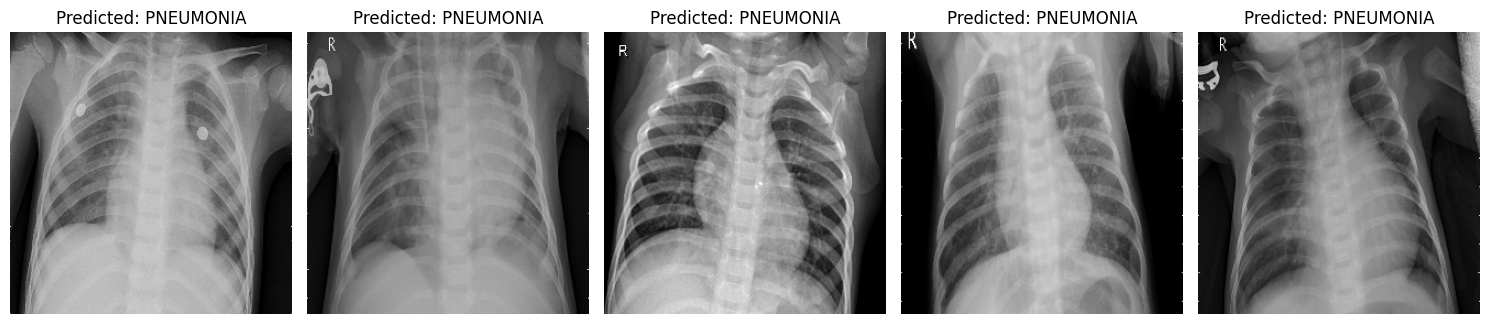

In [26]:
# Path to the directory containing the images
directory_path = '/content/chest_xray/test/PNEUMONIA'

# Select N image files from the directory
image_files = os.listdir(directory_path)[:5]

# Create a figure and axes for subplots
fig, axs = plt.subplots(1, len(image_files), figsize=(15, 5))

# Load and preprocess each image, make predictions, and display them using a loop
for i, image_file in enumerate(image_files):
    img_path = os.path.join(directory_path, image_file)
    # Load the image using OpenCV
    img = cv2.imread(img_path)
    # Resize the image to (256, 256)
    img = cv2.resize(img, (256, 256))
      # Normalize pixel values
    img_array = img.astype(np.float32) / 255.0

    # Expand the dimensions to match the input shape expected by the model
    img_array = np.expand_dims(img_array, axis=0)

    # Make predictions
    predictions = model.predict(img_array)
    actual_prediction = (predictions > 0.5).astype(int)

    # Display the image with predicted label
    # Convert BGR to RGB for displaying with matplotlib
    axs[i].imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    axs[i].axis('off')
    if actual_prediction[0][0] == 0:
        predicted_label = 'Normal'
    else:
        predicted_label = 'PNEUMONIA'
    axs[i].set_title(f'Predicted: {predicted_label}')

# Adjust layout
plt.tight_layout()
plt.show()

In [27]:
model.save_weights('model_weights_CNN.h5')

In [28]:
from keras.applications.vgg19 import VGG19
conv_base = VGG19(
    weights='imagenet',
    include_top = False,
    input_shape=(256,256,3)
)

80134624/80134624 [==============================] - 3s 0us/step


In [29]:
conv_base.summary()

Model: "vgg19"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 256, 256, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 256, 256, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 256, 256, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 128, 128, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 128, 128, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 128, 128, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 64, 64, 128)       0     

In [30]:
from keras.regularizers import l2
model_VGG19=Sequential()
model_VGG19.add(conv_base)
model_VGG19.add(Flatten())
model_VGG19.add(Dropout(0.25))
model_VGG19.add(Dense(128, activation='relu', kernel_regularizer=l2(0.05)))
model_VGG19.add(Dropout(0.2))
model_VGG19.add(Dense(32, activation='relu', kernel_regularizer=l2(0.05)))
model_VGG19.add(Dropout(0.2))
model_VGG19.add(Dense(1, activation='sigmoid'))


In [31]:
conv_base.trainable=False

In [32]:
model_VGG19.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg19 (Functional)          (None, 8, 8, 512)         20024384  
                                                                 
 flatten_1 (Flatten)         (None, 32768)             0         
                                                                 
 dropout_3 (Dropout)         (None, 32768)             0         
                                                                 
 dense_3 (Dense)             (None, 128)               4194432   
                                                                 
 dropout_4 (Dropout)         (None, 128)               0         
                                                                 
 dense_4 (Dense)             (None, 32)                4128      
                                                                 
 dropout_5 (Dropout)         (None, 32)               

In [33]:
model_VGG19.compile(optimizer = "rmsprop" ,
            loss = 'binary_crossentropy' ,
            metrics = ['accuracy'])

In [34]:
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

#Fitting Model
history_VGG19 = model_VGG19.fit_generator(train_ds,
                        epochs= 20,
                        validation_data = validation_ds,
                        callbacks = early_stopping)

Epoch 1/20
147/147 [==============================] - 64s 364ms/step - loss: 2.5191 - accuracy: 0.7802 - val_loss: 0.6820 - val_accuracy: 0.9098
Epoch 2/20
147/147 [==============================] - 44s 288ms/step - loss: 0.5786 - accuracy: 0.8503 - val_loss: 0.7429 - val_accuracy: 0.7083
Epoch 3/20
147/147 [==============================] - 40s 260ms/step - loss: 0.4522 - accuracy: 0.8694 - val_loss: 0.3040 - val_accuracy: 0.9405
Epoch 4/20
147/147 [==============================] - 39s 254ms/step - loss: 0.4183 - accuracy: 0.8669 - val_loss: 0.3212 - val_accuracy: 0.9424
Epoch 5/20
147/147 [==============================] - 50s 328ms/step - loss: 0.3905 - accuracy: 0.8658 - val_loss: 0.2837 - val_accuracy: 0.9405
Epoch 6/20
147/147 [==============================] - 56s 361ms/step - loss: 0.3876 - accuracy: 0.8652 - val_loss: 0.3215 - val_accuracy: 0.9079
Epoch 7/20
147/147 [==============================] - 48s 310ms/step - loss: 0.3819 - accuracy: 0.8701 - val_loss: 0.6606 - val_ac

In [35]:
# Evaluate the model on the validation dataset
validation_loss_VGG19, validation_accuracy_VGG19 = model_VGG19.evaluate(validation_ds)

# Print the validation loss and accuracy
print("Validation Loss:", validation_loss_VGG19)
print("Validation Accuracy:", validation_accuracy_VGG19)

17/17 [==============================] - 4s 180ms/step - loss: 0.2442 - accuracy: 0.9386
Validation Loss: 0.24417144060134888
Validation Accuracy: 0.9385796785354614


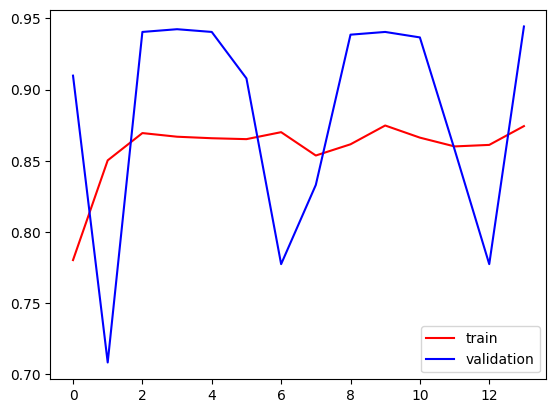

In [38]:
import matplotlib.pyplot as plt

plt.plot(history_VGG19.history['accuracy'],color='red',label='train')
plt.plot(history_VGG19.history['val_accuracy'],color='blue',label='validation')
plt.legend()
plt.show()

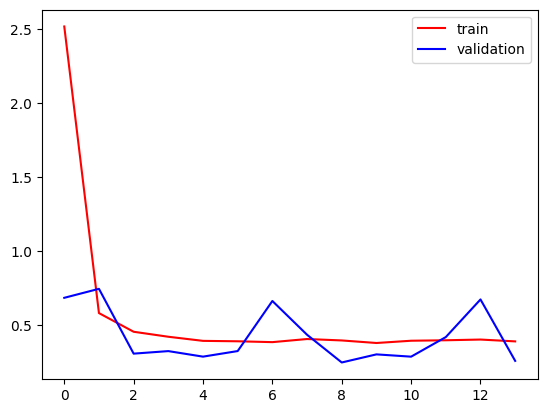

In [39]:
plt.plot(history_VGG19.history['loss'],color='red',label='train')
plt.plot(history_VGG19.history['val_loss'],color='blue',label='validation')
plt.legend()
plt.show()

Testing Images:
Found 624 files belonging to 2 classes.
Testing Images:
20/20 [==============================] - 9s 413ms/step


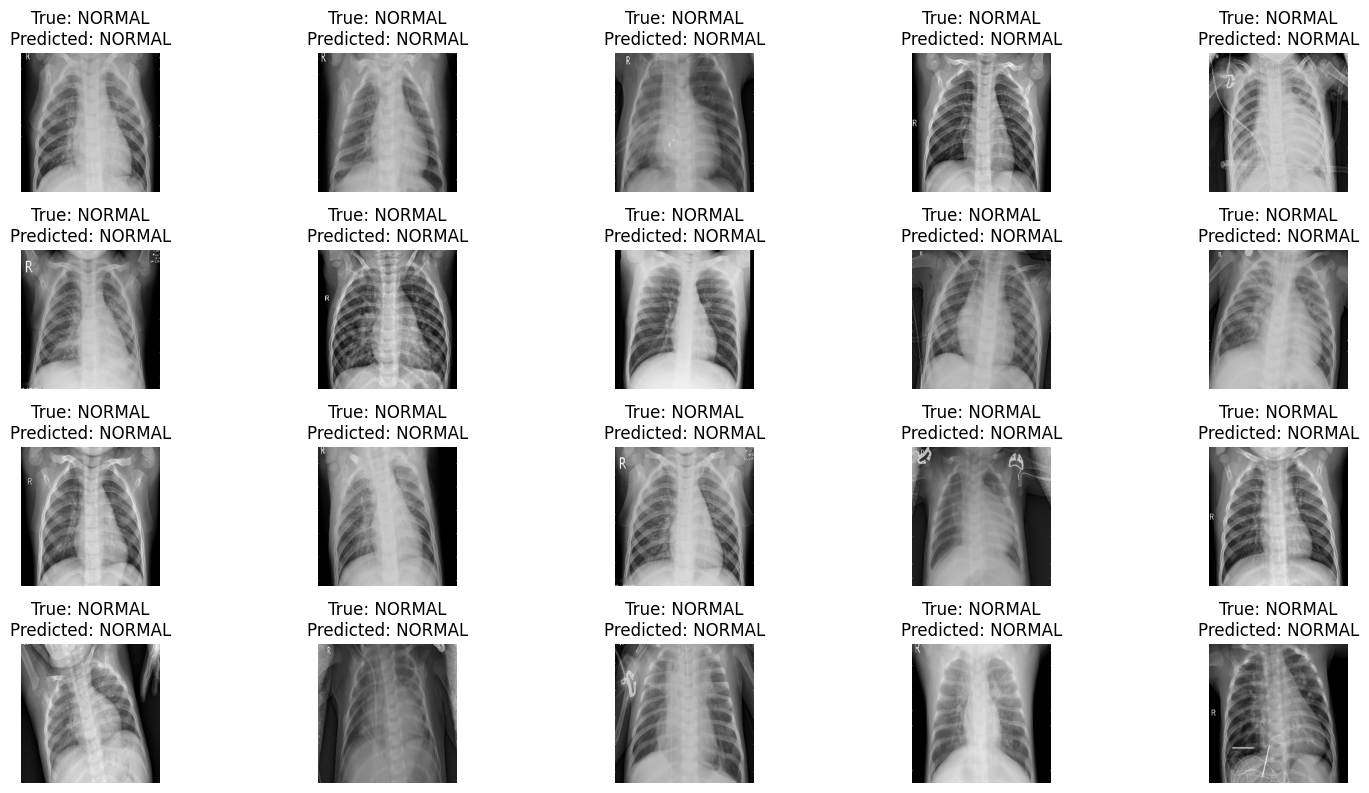

In [40]:
test_dir = '/content/chest_xray/test'
print('Testing Images:')
test_ds = tf.keras.utils.image_dataset_from_directory(
    test_dir,
    seed=123,
    image_size=IMAGE_SIZE,
    batch_size=32)

# Define a function to plot images with their true and predicted labels
def plot_images_with_predictions(model, dataset, class_labels, num_images=40, num_images_per_row=5):
    # Generate predictions for a set number of images
    predictions = model.predict(dataset)
    # Shuffle the dataset
    dataset_shuffled = dataset.shuffle(buffer_size=len(dataset))

    plt.figure(figsize=(15, 10))
    for i, (images, labels) in enumerate(dataset_shuffled.take(num_images)):
        # Convert tensor to NumPy array
        images = images.numpy()

        # Iterate over each image in the batch
        for j in range(len(images)):
            if i * num_images_per_row + j < num_images:  # Check if the total number of images exceeds the desired count
                predicted_class = class_labels[np.argmax(predictions[i * num_images_per_row + j])]
                true_class = class_labels[np.argmax(labels[j])]
                plt.subplot(num_images // num_images_per_row + 1, num_images_per_row, i * num_images_per_row + j + 1)
                plt.imshow(images[j].astype("uint8"))
                plt.title(f'True: {true_class}\nPredicted: {predicted_class}')
                plt.axis('off')

    plt.tight_layout()
    plt.show()

# Visualize predictions on random 20 images from the testing dataset
print('Testing Images:')
plot_images_with_predictions(model_VGG19, test_ds, class_labels, num_images=20)

1/1 [==============================] - 0s 20ms/step


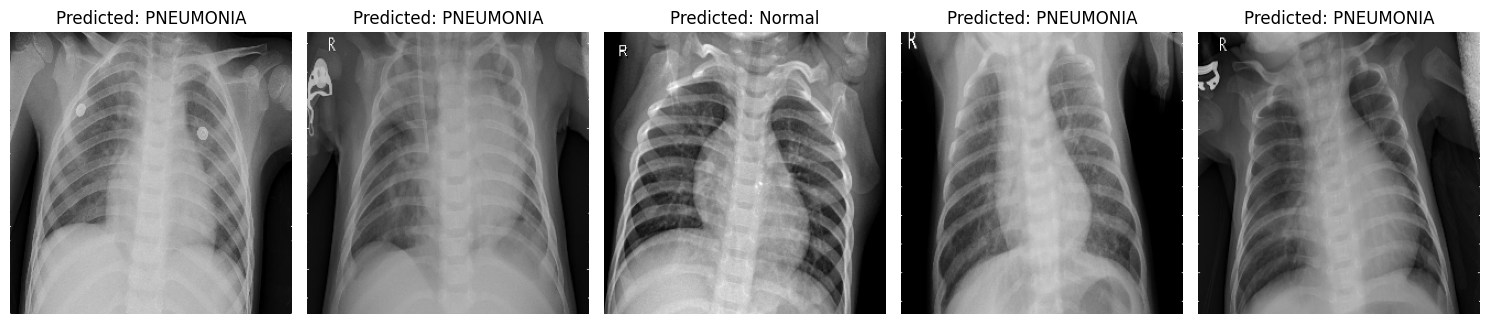

In [41]:
# Path to the directory containing the images
directory_path = '/content/chest_xray/test/PNEUMONIA'

# Select N image files from the directory
image_files = os.listdir(directory_path)[:5]

# Create a figure and axes for subplots
fig, axs = plt.subplots(1, len(image_files), figsize=(15, 5))

# Load and preprocess each image, make predictions, and display them using a loop
for i, image_file in enumerate(image_files):
    img_path = os.path.join(directory_path, image_file)
    # Load the image using OpenCV
    img = cv2.imread(img_path)
    # Resize the image to (256, 256)
    img = cv2.resize(img, (256, 256))
      # Normalize pixel values
    img_array = img.astype(np.float32) / 255.0

    # Expand the dimensions to match the input shape expected by the model
    img_array = np.expand_dims(img_array, axis=0)

    # Make predictions
    predictions = model_VGG19.predict(img_array)
    actual_prediction = (predictions > 0.5).astype(int)

    # Display the image with predicted label
    # Convert BGR to RGB for displaying with matplotlib
    axs[i].imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    axs[i].axis('off')
    if actual_prediction[0][0] == 0:
        predicted_label = 'Normal'
    else:
        predicted_label = 'PNEUMONIA'
    axs[i].set_title(f'Predicted: {predicted_label}')

# Adjust layout
plt.tight_layout()
plt.show()

In [50]:
model_VGG19.save_weights('model_weights_VGG19.h5')

In [42]:
# Load the Xception base model without the top (classification) layer
from keras.applications import Xception

base_model = Xception(weights='imagenet', include_top=False, pooling='avg', input_shape=(256, 256, 3))

base_model.trainable = False
model_Xcep = Sequential()

model_Xcep.add(base_model)
model_Xcep.add(BatchNormalization())
model_Xcep.add(Dropout(0.45))

model_Xcep.add(Dense(220, activation='relu'))
model_Xcep.add(Dropout(0.25))

model_Xcep.add(Dense(60,activation='relu'))
model_Xcep.add(Dense(1, activation='sigmoid'))

model_Xcep.summary()

83683744/83683744 [==============================] - 3s 0us/step
Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 xception (Functional)       (None, 2048)              20861480  
                                                                 
 batch_normalization_10 (Ba  (None, 2048)              8192      
 tchNormalization)                                               
                                                                 
 dropout_6 (Dropout)         (None, 2048)              0         
                                                                 
 dense_6 (Dense)             (None, 220)               450780    
                                                                 
 dropout_7 (Dropout)         (None, 220)               0         
                                                                 
 dense_7 (Dense)             (None, 60)                

In [43]:
# Compile
model_Xcep.compile(optimizer=Adamax(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy'])

In [44]:
#Early_Stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

#Fitting Model
history_Xcep = model_Xcep.fit_generator(train_ds,
                        epochs= 20,
                        validation_data = validation_ds,
                        callbacks = early_stopping)

Epoch 1/20
147/147 [==============================] - 66s 367ms/step - loss: 0.2079 - accuracy: 0.9112 - val_loss: 0.1685 - val_accuracy: 0.9655
Epoch 2/20
147/147 [==============================] - 40s 258ms/step - loss: 0.1325 - accuracy: 0.9436 - val_loss: 0.0945 - val_accuracy: 0.9750
Epoch 3/20
147/147 [==============================] - 44s 291ms/step - loss: 0.1181 - accuracy: 0.9546 - val_loss: 0.0726 - val_accuracy: 0.9731
Epoch 4/20
147/147 [==============================] - 46s 293ms/step - loss: 0.1087 - accuracy: 0.9591 - val_loss: 0.0661 - val_accuracy: 0.9750
Epoch 5/20
147/147 [==============================] - 46s 304ms/step - loss: 0.1027 - accuracy: 0.9595 - val_loss: 0.0668 - val_accuracy: 0.9731
Epoch 6/20
147/147 [==============================] - 38s 243ms/step - loss: 0.0899 - accuracy: 0.9670 - val_loss: 0.0661 - val_accuracy: 0.9770
Epoch 7/20
147/147 [==============================] - 41s 273ms/step - loss: 0.0870 - accuracy: 0.9687 - val_loss: 0.0619 - val_ac

In [45]:
# Evaluate the model on the validation dataset
validation_loss_Xcep, validation_accuracy_Xcep = model_Xcep.evaluate(validation_ds)

# Print the validation loss and accuracy
print("Validation Loss:", validation_loss_Xcep)
print("Validation Accuracy:", validation_accuracy_Xcep)

17/17 [==============================] - 5s 160ms/step - loss: 0.0563 - accuracy: 0.9808
Validation Loss: 0.05630116909742355
Validation Accuracy: 0.9808061122894287


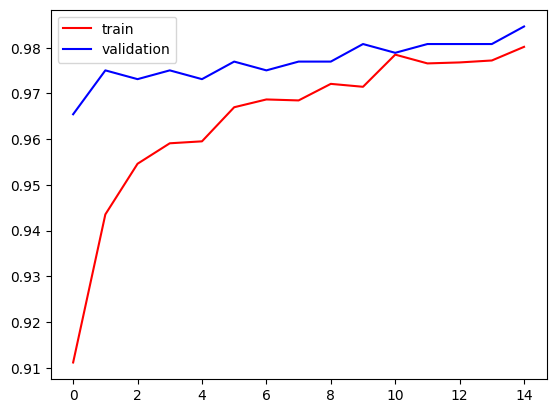

In [46]:
import matplotlib.pyplot as plt

plt.plot(history_Xcep.history['accuracy'],color='red',label='train')
plt.plot(history_Xcep.history['val_accuracy'],color='blue',label='validation')
plt.legend()
plt.show()

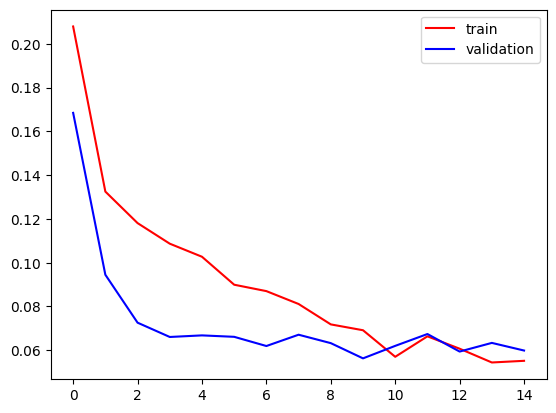

In [47]:
plt.plot(history_Xcep.history['loss'],color='red',label='train')
plt.plot(history_Xcep.history['val_loss'],color='blue',label='validation')
plt.legend()
plt.show()

Testing Images:
Found 624 files belonging to 2 classes.
Testing Images:
20/20 [==============================] - 9s 336ms/step


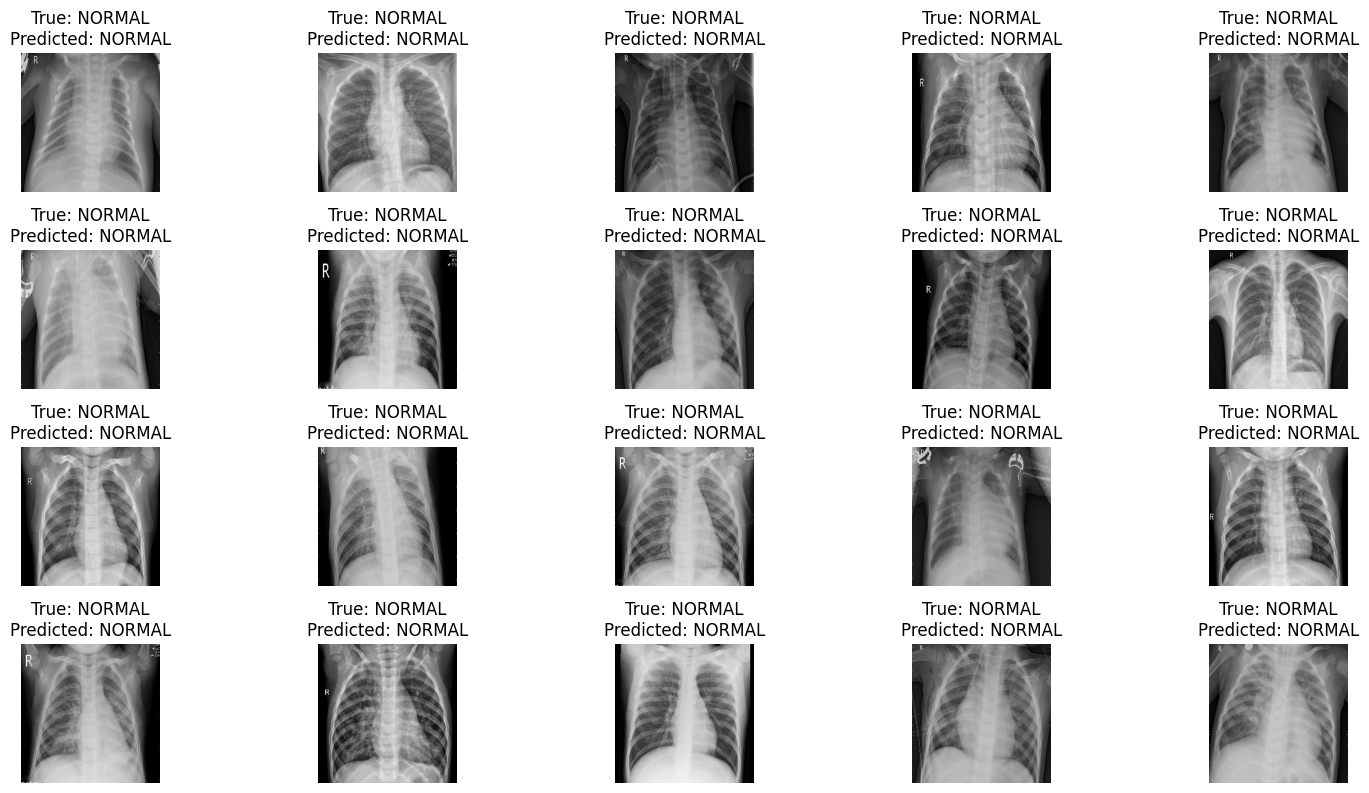

In [48]:
test_dir = '/content/chest_xray/test'
print('Testing Images:')
test_ds = tf.keras.utils.image_dataset_from_directory(
    test_dir,
    seed=123,
    image_size=IMAGE_SIZE,
    batch_size=32)

# Define a function to plot images with their true and predicted labels
def plot_images_with_predictions(model, dataset, class_labels, num_images=40, num_images_per_row=5):
    # Generate predictions for a set number of images
    predictions = model.predict(dataset)
    # Shuffle the dataset
    dataset_shuffled = dataset.shuffle(buffer_size=len(dataset))

    plt.figure(figsize=(15, 10))
    for i, (images, labels) in enumerate(dataset_shuffled.take(num_images)):
        # Convert tensor to NumPy array
        images = images.numpy()

        # Iterate over each image in the batch
        for j in range(len(images)):
            if i * num_images_per_row + j < num_images:  # Check if the total number of images exceeds the desired count
                predicted_class = class_labels[np.argmax(predictions[i * num_images_per_row + j])]
                true_class = class_labels[np.argmax(labels[j])]
                plt.subplot(num_images // num_images_per_row + 1, num_images_per_row, i * num_images_per_row + j + 1)
                plt.imshow(images[j].astype("uint8"))
                plt.title(f'True: {true_class}\nPredicted: {predicted_class}')
                plt.axis('off')

    plt.tight_layout()
    plt.show()

# Visualize predictions on random 20 images from the testing dataset
print('Testing Images:')
plot_images_with_predictions(model_Xcep, test_ds, class_labels, num_images=20)

1/1 [==============================] - 0s 106ms/step


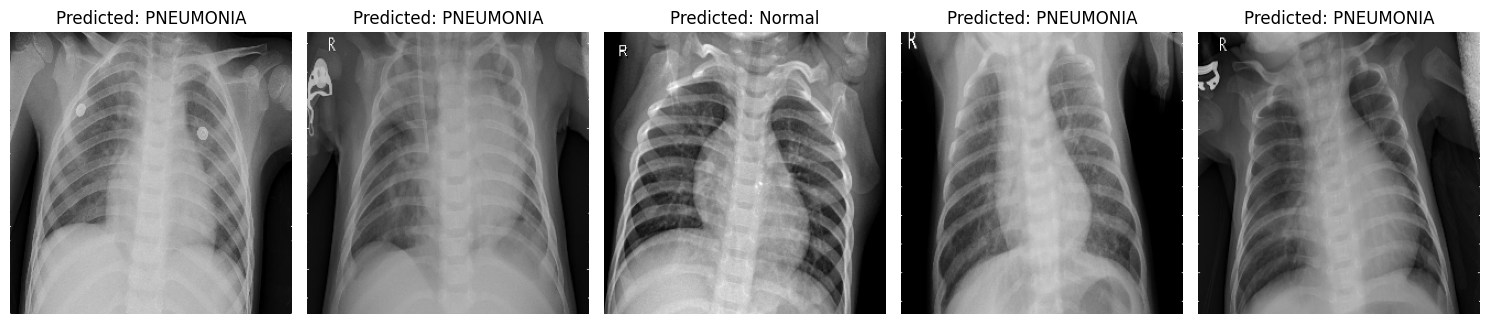

In [49]:
# Path to the directory containing the images
directory_path = '/content/chest_xray/test/PNEUMONIA'

# Select N image files from the directory
image_files = os.listdir(directory_path)[:5]

# Create a figure and axes for subplots
fig, axs = plt.subplots(1, len(image_files), figsize=(15, 5))

# Load and preprocess each image, make predictions, and display them using a loop
for i, image_file in enumerate(image_files):
    img_path = os.path.join(directory_path, image_file)
    # Load the image using OpenCV
    img = cv2.imread(img_path)
    # Resize the image to (256, 256)
    img = cv2.resize(img, (256, 256))
      # Normalize pixel values
    img_array = img.astype(np.float32) / 255.0

    # Expand the dimensions to match the input shape expected by the model
    img_array = np.expand_dims(img_array, axis=0)

    # Make predictions
    predictions = model_Xcep.predict(img_array)
    actual_prediction = (predictions > 0.5).astype(int)

    # Display the image with predicted label
    # Convert BGR to RGB for displaying with matplotlib
    axs[i].imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    axs[i].axis('off')
    if actual_prediction[0][0] == 0:
        predicted_label = 'Normal'
    else:
        predicted_label = 'PNEUMONIA'
    axs[i].set_title(f'Predicted: {predicted_label}')

# Adjust layout
plt.tight_layout()
plt.show()

In [51]:
model_Xcep.save_weights('model_weights_Xcep.h5')